In [1]:
import os
import sys
import yaml
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import src.preprocessing as preproc
from src.models import *

In [2]:
# Load config file
with open('../config/ideal.yaml', "r") as f:
    cfg = yaml.safe_load(f)
cfg['dataset']['path'] = '../data/aodisaggregation_emmisions_test_6.3_ACCMIP_200806.06_echam.nc'

# Load dataset
data = preproc.make_data(cfg=cfg, include_2d=False)

In [3]:
# Choose a calibration columns to evaluate model over
torch.random.manual_seed(cfg['evaluation']['calibration_seed'])
calib_idx = torch.randperm(len(data.h_by_column_std))[:200]

# Predict idealized exponential height profile
L = cfg['model']['L']
h_stddev = data.h_by_column.std()
prediction_3d = torch.exp(-data.h_by_column_std[calib_idx] / L)

# Rescale predictions by τ/∫φdh
aggregate_prediction = h_stddev * L * (torch.exp(-data.h_by_column_std[:, -1] / L) - torch.exp(-data.h_by_column_std[:, 0] / L))
correction = data.z_smooth[calib_idx] / aggregate_prediction[calib_idx]
prediction_3d = prediction_3d.mul(correction.unsqueeze(-1))

In [4]:
# Rescale distribution variance without shifting mean
def make_bext_dist(prediction_3d, sigma_ext):
    eps = torch.finfo(torch.float64).eps
    loc = torch.log(prediction_3d.clip(min=eps)) - sigma_ext.square().div(2)
    bext_dist = torch.distributions.LogNormal(loc=loc, scale=sigma_ext)
    return bext_dist

# Compute calibration plots for given region sizes
def compute_calibrations(bext_dist, sizes):
    calibration = []
    mu = bext_dist.mean
    for size in sizes:
        q_lb = (1 - size) / 2
        q_ub = 1 - q_lb
        lb = bext_dist.icdf(torch.tensor(q_lb))
        ub = bext_dist.icdf(torch.tensor(q_ub))
        lb_mask = data.gt_by_column[calib_idx] > lb
        ub_mask = data.gt_by_column[calib_idx] < ub
        region_mask = lb_mask & ub_mask
        calibration.append(region_mask.float().mean().item())
    return np.asarray(calibration)

# Compute deviation from perfect calibration
def ICI(calibration, sizes):
    return np.abs(calibration - sizes).mean()

In [5]:
# Range of shapes for bext
sigma_exts = np.arange(0.01, 5, 0.01)
sigma_ext_iters = tqdm.notebook.tqdm(sigma_exts)

# Confidence region sizes to consider
sizes = np.arange(0.05, 1.0, 0.2)

integrals = []
for sigma_ext in sigma_ext_iters:
    sigma_ext = torch.tensor(sigma_ext)
    bext_dist = make_bext_dist(prediction_3d, sigma_ext)
    calibration = compute_calibrations(bext_dist, sizes)
    integrals.append(ICI(calibration, sizes))
integrals = np.asarray(integrals)

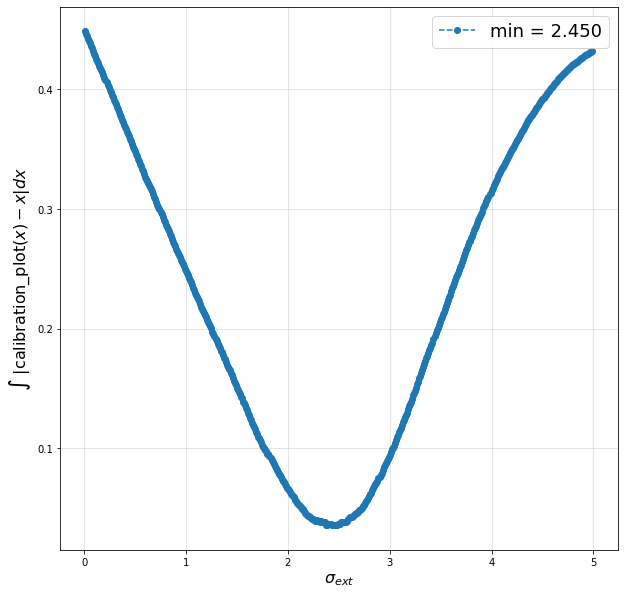

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

best_scale = sigma_exts[np.argmin(integrals)]
ax.plot(sigma_exts, integrals, '--o', label=f'min = {best_scale:.3f}')

ax.set_xlabel(r'$\sigma_{ext}$', fontsize=16)
ax.set_ylabel(r'$\int$ |calibration_plot$(x) - x|dx$ ', fontsize=16)
ax.grid(alpha=0.4)
plt.legend(fontsize=18)
plt.show()